<a href="https://colab.research.google.com/github/mm230/paddy-desease-classification/blob/main/paddy_desease_final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Import data</h1>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
import pandas as pd

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brro07","key":"9e5f1c5f50dc2d6079878f1f8859cc4c"}'}

In [6]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [8]:
!chmod 600 /content/kaggle.json

In [9]:
!kaggle competitions download -c paddy-disease-classification

 98% 1.00G/1.02G [00:24<00:00, 52.7MB/s]
100% 1.02G/1.02G [00:24<00:00, 44.9MB/s]


In [10]:
! mkdir paddy
! unzip paddy-disease-classification.zip
# ! rm -R ammi-2021-convnets.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train_images/downy_mildew/100992.jpg  
  inflating: train_images/downy_mildew/100995.jpg  
  inflating: train_images/downy_mildew/101015.jpg  
  inflating: train_images/downy_mildew/101020.jpg  
  inflating: train_images/downy_mildew/101022.jpg  
  inflating: train_images/downy_mildew/101024.jpg  
  inflating: train_images/downy_mildew/101034.jpg  
  inflating: train_images/downy_mildew/101050.jpg  
  inflating: train_images/downy_mildew/101078.jpg  
  inflating: train_images/downy_mildew/101096.jpg  
  inflating: train_images/downy_mildew/101103.jpg  
  inflating: train_images/downy_mildew/101114.jpg  
  inflating: train_images/downy_mildew/101119.jpg  
  inflating: train_images/downy_mildew/101142.jpg  
  inflating: train_images/downy_mildew/101177.jpg  
  inflating: train_images/downy_mildew/101178.jpg  
  inflating: train_images/downy_mildew/101181.jpg  
  inflating: train_images/downy_mildew

In [1]:
!pip install d2l==0.17.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision # load datasets
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
import albumentations as A
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import cv2
cudnn.benchmark = True
from PIL import Image
import glob
import os 
import seaborn as sns

# # Batch size during training
batch_size = 16
image_size = 325
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
data_dir = '/content/train_images'
test_data_dir = '/content/test/test_images'

In [3]:
train_transforms = transforms.Compose([
                              transforms.RandomRotation(30),
                              transforms.Resize(360),
                              transforms.RandomCrop(image_size),
                              transforms.RandomHorizontalFlip(0.3),
                              transforms.RandomVerticalFlip(0.3),
                              transforms.ToTensor(),
                              transforms.RandomErasing(0.1),
                              transforms.Normalize(mean=mean, std=std),
                          ])
test_transforms =transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std),
])
train_data = datasets.ImageFolder(root=data_dir ,  transform=train_transforms)   

In [4]:
classes = train_data.classes
classes

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [5]:
n = len(train_data)  # total number of examples
n_test = int(0.15 * n)  # take ~10% for test

test_set = torch.utils.data.Subset(train_data, range(n_test))  # take first 10%
train_set = torch.utils.data.Subset(train_data, range(n_test, n))  # take the rest   
len(train_set), len(test_set)

(8846, 1561)

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

len(train_loader), len(test_loader)

(553, 98)

In [7]:
from collections import Counter
# print(train_data.targets)
res = dict(Counter(train_data.targets))
print(res)
for key in res.keys():
  print(classes[key], res[key])

{0: 479, 1: 380, 2: 337, 3: 1738, 4: 965, 5: 1442, 6: 620, 7: 1594, 8: 1764, 9: 1088}
bacterial_leaf_blight 479
bacterial_leaf_streak 380
bacterial_panicle_blight 337
blast 1738
brown_spot 965
dead_heart 1442
downy_mildew 620
hispa 1594
normal 1764
tungro 1088


In [8]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

torch.Size([16, 3, 325, 325])
tensor([4, 4, 9, 4, 9, 8, 5, 7, 7, 3, 6, 9, 8, 8, 4, 4])


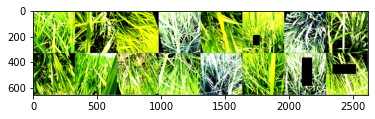

brown_spot brown_spot tungro brown_spot tungro normal dead_heart hispa hispa blast downy_mildew tungro normal normal brown_spot brown_spot


In [9]:
dataiter = iter(train_loader)
features, labels = dataiter.next()
# call function on our images
print(features.shape)
print(labels)
imshow(torchvision.utils.make_grid(features))
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

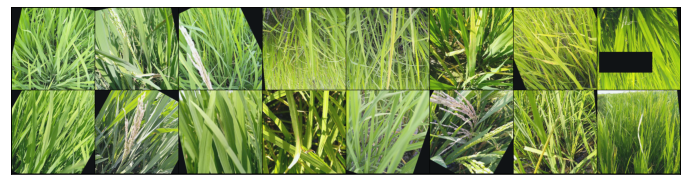

In [10]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(torchvision.utils.make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_loader)

<h1>Preprocess data </h1>

<h1>Train and Test data </h1>

In [11]:
from d2l import torch as d2l
torch.cuda.empty_cache()
torch.manual_seed(17)

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [13]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model."""

    # Make sure model is in training mode.
    model.train()

    # Move model to the device (CPU or GPU).
    model.to(device)

    # Exponential moving average of the loss.
    ema_loss = None

    # Loop over epochs.
    for epoch in range(num_epochs):

        # Loop over data.
        for batch_idx, (data, target) in enumerate(data_loader):

            # Forward pass.
            output = model(data.to(device))
            loss = criterion(output.to(device), target.to(device))

            # Backward pass.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # NOTE: It is important to call .item() on the loss before summing.
            if ema_loss is None:
                ema_loss = loss.item()
            else:
                ema_loss += (loss.item() - ema_loss) * 0.01

        # Print out progress the end of epoch.
        print(
            "Train Epoch: {} \tLoss: {:.6f}".format(epoch, ema_loss),
        )


def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0

    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():

        # Loop over test data.
        for data, target in data_loader:

            # Forward pass.
            output = model(data.to(device))

            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)

            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100.0 * correct / len(data_loader.dataset)
    print(f"Accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)")
    return percent

Tuning


In [14]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, train_data, test_data, batch_size=16, num_epochs=10,
                      param_group=True):

    train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,)
    test_iter = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)

    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

<h2>Train with all the data </h2>


In [15]:
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

<weakproxy at 0x7f09552a5fb0 to Device at 0x7f09475faad0>

loss 0.164, train acc 0.948, test acc 0.977
10.7 examples/sec on [device(type='cuda', index=0)]


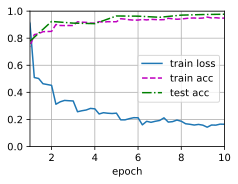

In [16]:
n = len(train_data) 
n_test = int(0.2 * n)  # take ~10% for test
print(n_test, n)
test_set = torch.utils.data.Subset(train_data, range(n_test))  # take first 10%

# finetune_net = torchvision.models.resnet50(pretrained=True) #loss 0.340, train acc 0.885, test acc 0.140 #best 
finetune_net = torchvision.models.resnext101_32x8d(pretrained=True) # 
train_fine_tuning(finetune_net, 1e-4, train_data, test_set, num_epochs= 10)

<h1>final<h1>


In [17]:
!mkdir /content/test/

In [18]:
!mv test_images/ /content/test/

In [19]:
test_transforms =transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                              #  transforms.Normalize(mean=mean, std=std),
                              transforms.Normalize(mean=mean, std=std),
])
test_data_dir = '/content/test'
# test_path=glob.glob
final_test_data = datasets.ImageFolder(root=test_data_dir ,  transform=test_transforms)  
final_test_loader = torch.utils.data.DataLoader(final_test_data, batch_size=batch_size)


In [20]:
def final_test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    # Make sure the model is in evaluation mode.

    model.eval()
    correct = 0
    result = None
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():

        # Loop over test data.
        for data, target in data_loader:
            # print(data.dataset)
            # Forward pass.
            output = model(data.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)

            if result is not None:
              result = torch.concat((result, pred), axis=0)
            else: 
              result = pred

    print(result.shape)
    return result 

In [21]:
# pred = final_test(model, final_test_loader)
# pred = final_test(conv_model, final_test_loader)
pred = final_test(finetune_net, final_test_loader)

columns = ['image_id','label']
df = pd.DataFrame(columns=columns)

df['image_id'] = final_test_loader.dataset.samples
df['label'] = pred.squeeze().detach().cpu().numpy()

df['image_id'] = df['image_id'].apply(lambda x: x[0].split('/')[-1])
df['label'] = df['label'].apply(lambda x: classes[x])

df['sort'] = df['image_id'].str.extract('(\d+)', expand=False).astype(int)
df.sort_values('sort',inplace=True, ascending=True)
df = df.drop('sort', axis=1)
print(df),

torch.Size([3469, 1])
        image_id                  label
0     200001.jpg                  hispa
1     200002.jpg                 normal
2     200003.jpg                  blast
3     200004.jpg                  blast
4     200005.jpg                  blast
...          ...                    ...
3464  203465.jpg             dead_heart
3465  203466.jpg                  hispa
3466  203467.jpg                 normal
3467  203468.jpg  bacterial_leaf_streak
3468  203469.jpg             dead_heart

[3469 rows x 2 columns]


(None,)

In [22]:
df.to_csv('submission_resnext101_32x8d.csv', index = False)